# Load Libraries

In [8]:
# basic
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# for reading the data
from nbodykit.source.catalog import BigFileCatalog
from nbodykit.transform import ConcatenateSources, CartesianToEquatorial

# astropy
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import z_at_value

In [9]:
work_dir = '/lustre/work/akira.tokiwa/LensingSSC'

sys.path.append(work_dir+'/lib')

from mpl_aea.mpl_aea import healpix

# Load Data

In [10]:
# the data directory
data_dir = '/lustre/work/akira.tokiwa/supersample/'
sample_path = data_dir + 'rfof_proc128_nc1024_size5000_nsteps60lin_ldr0_rcvnil_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_4096_rfofkdt_8/'

In [11]:
# read the data
rfof = BigFileCatalog(sample_path + "rfof_1.0000", dataset='RFOF/', header='header')
hpix = BigFileCatalog(sample_path + "usmesh", dataset='HEALPIX/', header='header')
meshs = BigFileCatalog(sample_path + "usmesh", dataset='1/', header='header')
mesh_rfof = BigFileCatalog(sample_path + "usmesh", dataset='RFOF/', header='header')

/home/akira.tokiwa/.conda/envs/cfastpm/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [12]:
# print the header
print("Read RFOF, columns = ", rfof.columns)
print("Read HEALPIX, columns = ", hpix.columns)
print("Read mesh, columns = ", meshs.columns)
print("Read mesh_rfof, columns = ", mesh_rfof.columns)

Read RFOF, columns =  ['ID', 'InitialPosition', 'Length', 'MinID', 'Position', 'RVdisp', 'Rdisp', 'Selection', 'Task', 'Value', 'Vdisp', 'Velocity', 'Weight']
Read HEALPIX, columns =  ['Aemit', 'ID', 'Mass', 'Rmom', 'Selection', 'Value', 'Weight']
Read mesh, columns =  ['Aemit', 'ID', 'Position', 'Selection', 'Value', 'Velocity', 'Weight']
Read mesh_rfof, columns =  ['Aemit', 'ID', 'Length', 'MinID', 'Position', 'RVdisp', 'Rdisp', 'Selection', 'Task', 'Value', 'Vdisp', 'Velocity', 'Weight']


# Functions

In [13]:
def read_range(cat, amin, amax):
    """ Read a portion of the lightcone between two red shift ranges
        The lightcone from FastPM is sorted in Aemit and an index is built.
        So we make use of that.
        CrowCanyon new runs are full sky
    """
    edges = cat.attrs['aemitIndex.edges']
    offsets = cat.attrs['aemitIndex.offset']
    start, end = edges.searchsorted([amin, amax])
    if cat.comm.rank == 0:
        cat.logger.info("Range of index is %d to %d" %(( start + 1, end + 1)))
    start = offsets[start + 1]
    end = offsets[end + 1]

    cat =  cat.query_range(start, end)
    if cat.csize > 0:
        cat['RA'], cat['DEC'] = CartesianToEquatorial(cat['Position'], frame='galactic')
    else:
        cat['RA'] = 0
        cat['DEC'] = 0
    return cat

# Plots

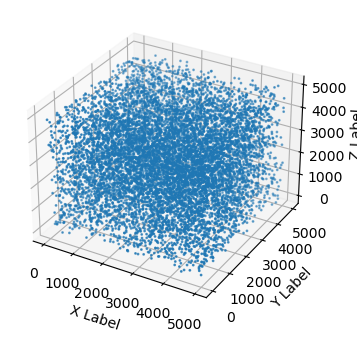

In [29]:
# visualize the data
pos_rfof = rfof['Position']
random_index = np.random.randint(0, len(pos_rfof), np.min([len(pos_rfof), 10000]))
pos_rfof = pos_rfof[random_index].compute()

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_rfof[:, 0], pos_rfof[:, 1], pos_rfof[:, 2], s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [41]:
meshs['ID']

dask.array<array, shape=(4425110519,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>

In [40]:
hpix['ID']

/home/akira.tokiwa/.conda/envs/cfastpm/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


dask.array<array, shape=(3156362364,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>

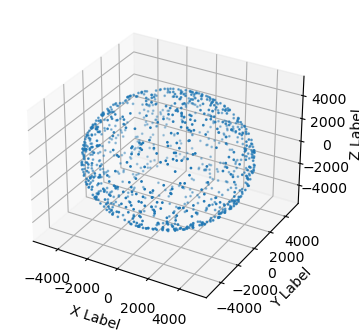

In [36]:
pos_mesh = meshs['Position']
random_index = np.random.randint(0, len(pos_mesh), np.min([len(pos_mesh), 10000]))
pos_mesh = pos_mesh[:1000].compute()


fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_mesh[:, 0], pos_mesh[:, 1], pos_mesh[:, 2], s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [1]:
# Define the cosmological parameters
H0 = 67.74 * u.km/u.s/u.Mpc  # Hubble constant
Omega_m = 0.3089  # Matter density

# Create a Flat Lambda CDM cosmology
cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_m)

# Function to calculate redshift from comoving distance
def redshift_from_comoving_distance(comoving_distance):
    comoving_distance = comoving_distance * u.Mpc
    # Calculate redshift
    z = z_at_value(cosmo.comoving_distance, comoving_distance)
    return z.value

# Example usage
for i in range(10):
    physical_distance = 500* (0.5+i)  # in Mpc
    estimated_redshift = redshift_from_comoving_distance(physical_distance)
    print(f"{i+1} & {physical_distance:.0f} & {estimated_redshift:.3f} \\")

1 & 250 & 0.057 \
2 & 750 & 0.177 \
3 & 1250 & 0.305 \
4 & 1750 & 0.443 \
5 & 2250 & 0.593 \
6 & 2750 & 0.759 \
7 & 3250 & 0.942 \
8 & 3750 & 1.148 \
9 & 4250 & 1.382 \
10 & 4750 & 1.649 \


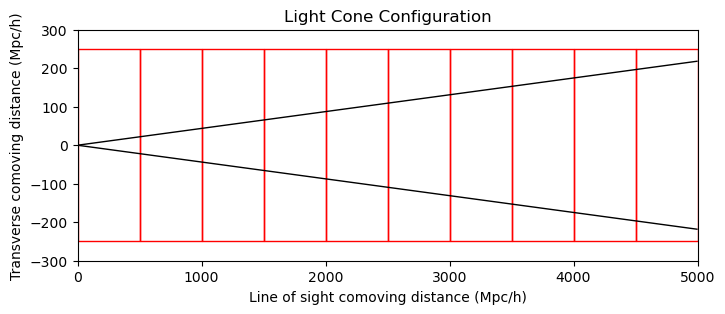

In [5]:
# Define the size of the boxes and the number of boxes
box_size = 500  # in Mpc/h
num_boxes = 10

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))

# Plotting the boxes
for i in range(num_boxes):
    rect = plt.Rectangle((i * box_size,-250), box_size, box_size, 
                         linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
# Angle in degrees
angle_deg = 2.5
# Convert angle to radians
angle_rad = np.radians(angle_deg)

# Length of the line (chosen to span the grid)
line_length = num_boxes * box_size

# Calculate the end point of the line
end_x = line_length * np.cos(angle_rad)
end_y = line_length * np.sin(angle_rad)

# Draw the line
ax.plot([0, end_x], [0, end_y], color='black', linewidth=1)
ax.plot([0, end_x], [0, -end_y], color='black', linewidth=1)

# Setting the limits of the plot
ax.set_xlim(0, num_boxes * box_size)
ax.set_ylim(-300, 300)

# Labeling the axes
ax.set_xlabel('Line of sight comoving distance (Mpc/h)')
ax.set_ylabel('Transverse comoving distance (Mpc/h)')
ax.set_title('Light Cone Configuration')

# Show the plot
plt.savefig(f"{work_dir}/img/config.png", dpi=200, bbox_inches='tight', pad_inches=0.1 )